In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# Load Data
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-31')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.650659
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.718646
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.859850
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.994284
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.973674
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762


In [ ]:
df.shape

(2265, 6)

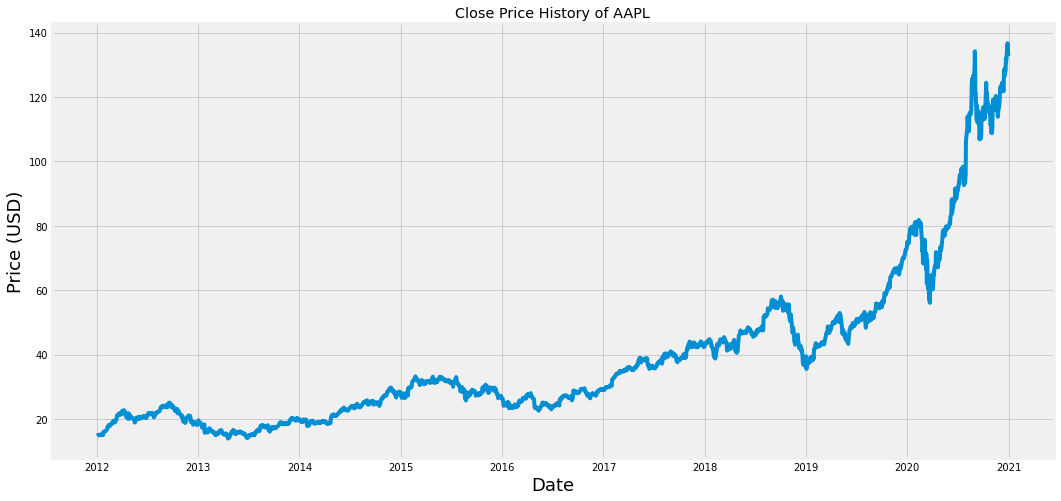

In [ ]:
# Visualize the Data
plt.figure(figsize=(16,8))
plt.title('Close Price History of AAPL')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price (USD)',fontsize=18)
plt.show()

Here we can see the close price of AAPL in the form of line chart.

In [ ]:
# Create dataframe with only Close column
data = df.filter(['Close'])

# Convert to numpy array
dataset = data.values

# Get number of rows to train the model on (80% of the data will be used to train)
training_data_len = math.ceil(len(dataset) * .8)
print(training_data_len)

1812


In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(scaled_data)

[[0.00602306]
 [0.0066661 ]
 [0.00800165]
 ...
 [0.98517215]
 [0.97580299]
 [0.96741145]]


In [ ]:
# Create training dataset
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [ ]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# Reshape data (bcs LSTM expect the input to be 3D, currently 2D)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1752, 60, 1)

In [ ]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1752/1752 [==============================] - 40s 21ms/step - loss: 7.2082e-04


In [ ]:
# Create test dataset
# Create new array containing scaled values from index 1752 to 2265
test_data = scaled_data[training_data_len - 60:, :]
# Create x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
# Convert data to numpy array
x_test = np.array(x_test)

In [ ]:
# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_train.shape

(1752, 60, 1)

In [ ]:
# Get models predicted data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Get RMSE
rmse = np.sqrt( np.mean(predictions - y_test) **2 )
print(rmse)

2.365214964675061


The model that has been created have the RMSE (Root Mean Square Error) of 2.37. This is means the model is pretty accurate in predicting AAPL stock price.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


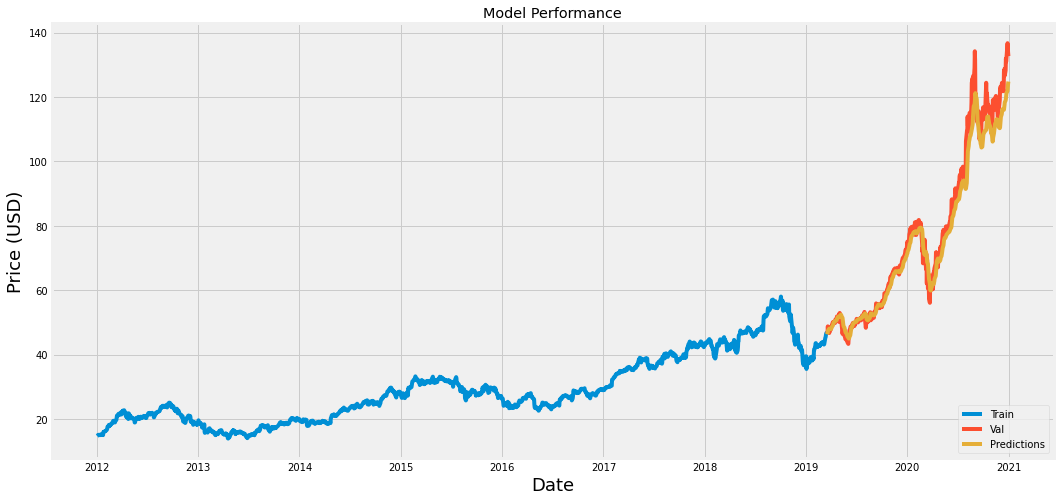

In [ ]:
# Plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model Performance')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

The blue line refers to the original price data (train data), orange line is the original price data that is not used to train the data (validation data), and the yellow line is the predicted price.

In [ ]:
def predict_price(last_date):
  '''
    This function is used to predict the closing price of AAPL stock.
    The input is the previous date of the predicted date.
    The output is the predicted close price of AAPL stock.
  '''
  quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=last_date)
  df = quote.filter(['Close'])
  last_60 = df[-60:].values
  last_60_scaled = scaler.transform(last_60)
  X_test = []
  X_test.append(last_60_scaled)
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  pred = model.predict(X_test)
  pred = scaler.inverse_transform(pred)

  return pred

In [ ]:
next_day_price = predict_price('2021-03-17')
print(next_day_price)

[[116.142525]]


The cell above is the example of predicting AAPL close price. It predicts that on 18 March 2021, the close price will be 116.14 USD.